In [1]:
from sfm import *
%matplotlib inline

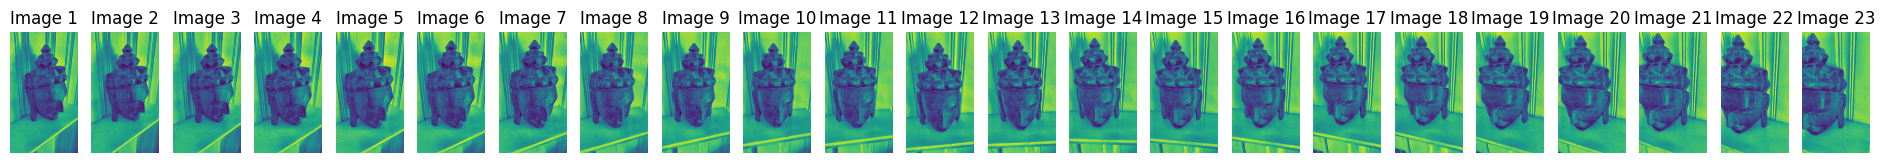

In [2]:
sfmh = sfm_helpers("buddha_images", False)
images = sfmh.getImages()

In [3]:
#MAIN CODE FOR INITIAL TRIANGULATION
pc = point_cloud()
pc.camera_poses.append(np.eye(4)) # First camera pose is origin
pc.gtsam_camera_poses.append(np.linalg.inv(pc.camera_poses[0]))


for i in range(len(images)-1):
    print(f"\n\nidx = {i}")
    if i==0:
        src_pts, dst_pts, good_matches = sfmh.findAndMatchFeatures(images[i], images[i+1], 1000)
    else:
        src_pts, dst_pts, good_matches = sfmh.findAndMatchFeatures(images[i], images[i+1], 5000)
    print(f"Number of good matched between images {i} and {i+1} = {len(good_matches)}")
    E, src_pts, dst_pts = sfmh.essentialMat(src_pts, dst_pts)

    if i==0:
        R, t = sfmh.posesFromE(E, src_pts, dst_pts)
        TrMat = np.vstack((np.hstack((R, t.reshape(3,1))), np.array([0, 0, 0, 1])))
        pc.camera_poses.append(TrMat)
        pc.gtsam_camera_poses.append(np.linalg.inv(TrMat))

        print(f"Camera pose: {TrMat}")

        P1 = np.array(sfmh.K @ pc.camera_poses[i][:3,:])
        P2 = np.array(sfmh.K @ pc.camera_poses[i+1][:3,:])

        pts_3d, src_pts, dst_pts = sfmh.triangulate_pts(P1, P2, src_pts, dst_pts)
        
        pc.addPoints(pts_3d, src_pts, dst_pts, i, i+1)

    else:
        common_3d, common_2d_dst = pc.common_pts(src_pts, dst_pts)
        print(f"Number of 3D and 2D common points: {common_3d.shape}, {common_2d_dst.shape}")

        TrMat = sfmh.posesFromPnP(common_3d, common_2d_dst)
        pc.camera_poses.append(TrMat)
        pc.gtsam_camera_poses.append(np.linalg.inv(TrMat))

        P1 = sfmh.K @ pc.camera_poses[i][:3,:]
        P2 = sfmh.K @ pc.camera_poses[i+1][:3,:]

        pts_3d, src_pts, dst_pts = sfmh.triangulate_pts(P1, P2, src_pts, dst_pts)
        pc.addPoints(pts_3d, src_pts, dst_pts, i, i+1)




idx = 0
Number of good matched between images 0 and 1 = 156
Camera pose: [[ 0.99995967 -0.00389335  0.00809269 -0.49982572]
 [ 0.00387289  0.99998927  0.00254285 -0.02705316]
 [-0.00810251 -0.0025114   0.99996402 -0.8657034 ]
 [ 0.          0.          0.          1.        ]]
pts_3d shape before masking = (4, 102)
pts_3d shape after masking = (3, 102)
Number of tracks: 102


idx = 1
Number of good matched between images 1 and 2 = 419
Number of 3D and 2D common points: (49, 3), (49, 2)
pts_3d shape before masking = (4, 263)
pts_3d shape after masking = (3, 261)
Number of tracks: 314


idx = 2
Number of good matched between images 2 and 3 = 234
Number of 3D and 2D common points: (49, 3), (49, 2)
pts_3d shape before masking = (4, 111)
pts_3d shape after masking = (3, 111)
Number of tracks: 376


idx = 3
Number of good matched between images 3 and 4 = 213
Number of 3D and 2D common points: (34, 3), (34, 2)
pts_3d shape before masking = (4, 110)
pts_3d shape after masking = (3, 108)
Numb

In [4]:
pc.filter_points(90)
pts_3d_plot = np.array([point for point in pc.tracks.keys()])
print(f"Number of 3D points in the point cloud = {len(pts_3d_plot)}")
pcPlot = plotter(pts_3d_plot, pc.gtsam_camera_poses, 4000)
pcPlot.plot_3d_go()

Number of 3D points in the point cloud = 2295


In [5]:
# Optimization using gtsam
optimizer = gtsam_optimizer(pc, sfmh.K)

#Initilize the factor graph
graph, initial_estimate, L, X = optimizer.initialize_factor_graph()
print('Initial Error = {}'.format(graph.error(initial_estimate)))

# Optimize the graph and get the results
result = optimizer.optimize()
print('Final Error = {}'.format(graph.error(result)))

No. of factors = 2295
Initial Error = 1318.424644136807
Initial error: 1318.42, values: 2318
Final Error = 72.29567678060265
iter      cost      cost_change    lambda  success iter_time
   0  5.570988e+07   -5.57e+07    1.00e-05     1    4.43e-02
iter      cost      cost_change    lambda  success iter_time
   0  9.837007e+03   -8.52e+03    1.00e-04     1    3.55e-02
iter      cost      cost_change    lambda  success iter_time
   0  4.023470e+02    9.16e+02    1.00e-03     1    4.79e-02
   1  1.047196e+04   -1.01e+04    1.00e-04     1    3.91e-02
   1  2.652387e+02    1.37e+02    1.00e-03     1    3.57e-02
   2  6.590654e+03   -6.33e+03    1.00e-04     1    4.22e-02
   2  1.788188e+02    8.64e+01    1.00e-03     1    3.59e-02
   3  4.802096e+03   -4.62e+03    1.00e-04     1    3.91e-02
   3  1.396694e+02    3.91e+01    1.00e-03     1    3.36e-02
   4  2.565400e+03   -2.43e+03    1.00e-04     1    3.56e-02
   4  1.151876e+02    2.45e+01    1.00e-03     1    4.17e-02
   5  1.754037e+03   

In [6]:
# Plot Optimized point cloud
opt_camera_poses = []
optimized_pt_cloud = []

i = 0
for point in pc.tracks.keys():
    # print(point)
    # for j, measurement in enumerate(point):
    optimized_pt_cloud.append(result.atPoint3(L(i)))
        #print(f"Optimized 3D point {i} = {result.atPoint3(L(i))}")
    i+=1

optimized_poses = []
for i in range(len(images)):
    opt_camera_poses.append(result.atPose3(X(i)).matrix())
    R = opt_camera_poses[i][:3,:3]
    T = opt_camera_poses[i][:3,3]
    Tr = np.hstack((R, T.reshape(3, 1)))
    optimized_poses.append(Tr)

print(len(optimized_poses))
# plot_poses(optimized_poses, final=True)
# print(f"Optimized 3D points = {np.array((optimized_pt_cloud))}")
opt_pcPlot = plotter(np.array(optimized_pt_cloud), np.array(optimized_poses), 400)
opt_pcPlot.plot_3d_go()

23
Optimized 3D points = [[ 14.69357487 -31.0472279  105.97547616]
 [ 17.40624759 -36.22248183 123.15251943]
 [ 15.81106844 -20.93389246  86.82819693]
 ...
 [ 11.22276397 -27.63466962  95.34364732]
 [ 20.87841243  14.47979503 122.63669436]
 [  6.83857429 -30.0620242   85.82534411]]
